In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gekko import GEKKO

# # Import or generate data
# filename = 'tclab_dyn_data2.csv'
# try:
#     data = pd.read_csv(filename)
# except:
#     url = 'https://apmonitor.com/do/uploads/Main/tclab_dyn_data2.txt'
#     data = pd.read_csv(url)
    
    


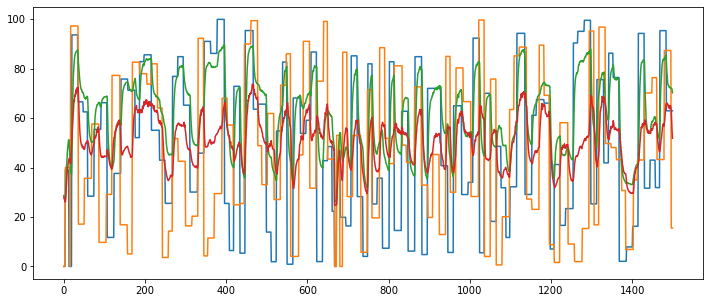

In [2]:
data = pd.read_pickle('TCLab_MIMO_Data_narrow_wide_resampled.pkl')

plt.figure(figsize=(12,5))
plt.plot(data)

In [3]:
# Create GEKKO Model
m = GEKKO(remote=True)
interval = 30
m.time = np.linspace(0, len(data)*interval-interval, len(data))

# Parameters to Estimate
U = m.FV(value=10,lb=1,ub=20)
alpha1 = m.FV(value=0.01,lb=0.003,ub=0.03)  # W / % heater
alpha2 = m.FV(value=0.005,lb=0.002,ub=0.02) # W / % heater

# STATUS=1 allows solver to adjust parameter
U.STATUS = 1  
alpha1.STATUS = 1 
alpha2.STATUS = 1 

# Measured inputs
Q1 = m.MV(value=data['H1'].values)
Q2 = m.MV(value=data['H2'].values)

# State variables
TC1 = m.CV(value=data['T1'].values)
TC1.FSTATUS = 1    # minimize fstatus * (meas-pred)^2
TC2 = m.CV(value=data['T2'].values)
TC2.FSTATUS = 1    # minimize fstatus * (meas-pred)^2

Ta = m.Param(value=23.0+273.15)     # K
mass = m.Param(value=4.0/1000.0)    # kg
Cp = m.Param(value=0.5*1000.0)      # J/kg-K    
A = m.Param(value=10.0/100.0**2)    # Area not between heaters in m^2
As = m.Param(value=2.0/100.0**2)    # Area between heaters in m^2
eps = m.Param(value=0.9)            # Emissivity
sigma = m.Const(5.67e-8)            # Stefan-Boltzmann

# Heater temperatures in Kelvin
T1 = m.Intermediate(TC1+273.15)
T2 = m.Intermediate(TC2+273.15)

# Heat transfer between two heaters
Q_C12 = m.Intermediate(U*As*(T2-T1)) # Convective
Q_R12 = m.Intermediate(eps*sigma*As*(T2**4-T1**4)) # Radiative

# Semi-fundamental correlations (energy balances)
m.Equation(TC1.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T1) \
                    + eps * sigma * A * (Ta**4 - T1**4) \
                    + Q_C12 + Q_R12 \
                    + alpha1*Q1))

m.Equation(TC2.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T2) \
                    + eps * sigma * A * (Ta**4 - T2**4) \
                    - Q_C12 - Q_R12 \
                    + alpha2*Q2))

# Options
m.options.IMODE   = 5 # MHE
m.options.EV_TYPE = 2 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 3 # IPOPT

# Solve
m.solve(disp=True)

# Parameter values
print('U     : ' + str(U.value[0]))
print('alpha1: ' + str(alpha1.value[0]))
print('alpha2: ' + str(alpha2.value[0]))



apm 10.37.9.8_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:          11995
 Number of total equations: -        11992
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              3
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt

In [4]:
m.time[0:10]

array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270.])

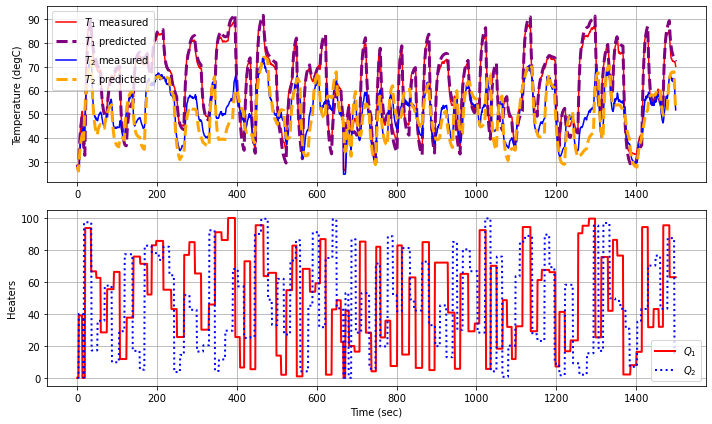

In [5]:
# Create plot
plt.figure(figsize=(10,6))
ax=plt.subplot(2,1,1)
ax.grid()
plt.plot(data['T1'].to_numpy(),'r-',label=r'$T_1$ measured')
plt.plot(TC1.value,color='purple',linestyle='--',\
         lw=3,label=r'$T_1$ predicted')
plt.plot(data['T2'].to_numpy(),'b-',label=r'$T_2$ measured')
plt.plot(TC2.value,color='orange',linestyle='--',\
         lw=3,label=r'$T_2$ predicted')
plt.ylabel('Temperature (degC)')
plt.legend(loc=2)
ax=plt.subplot(2,1,2)
ax.grid()
plt.plot(data['H1'],'r-',\
         lw=2,label=r'$Q_1$')
plt.plot(data['H2'],'b:',\
         lw=2,label=r'$Q_2$')
plt.ylabel('Heaters')
plt.xlabel('Time (sec)')
plt.legend(loc='best')

plt.tight_layout()
plt.show()